In [830]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [831]:
cat = pd.read_csv('similar-staff-picks-challenge-categories.csv')
clipcat = pd.read_csv('similar-staff-picks-challenge-clip-categories.csv')
clip = pd.read_csv('similar-staff-picks-challenge-clips.csv')

In [832]:
clip = clip.sort_values('clip_id') ## Sorting by clip_id will make later steps easier

# I. Checking for null values:

In [833]:
cat.isnull().sum()

category_id    0
parent_id      0
name           0
dtype: int64

In [834]:
clipcat.isnull().sum()

clip_id       0
categories    0
dtype: int64

In [835]:
clip.isnull().sum()

Unnamed: 0          0
id                  0
title               0
caption           105
created             0
filesize            0
duration            0
clip_id             0
total_comments      0
total_plays         0
total_likes         0
thumbnail           0
dtype: int64

In [836]:
##Replace 105 null values in 'caption' column of clip dataframe with empty string
clip = clip.fillna('')

# II. Creating a more meaningful metric for clip creation time:

### Ensuring time strings follow predictable format

In [837]:
## We have to slice to correct the date formats before converting to datetime objects
## As shown below, the format is standardized. Therefore we can slice.
print(clip.created.apply(lambda x: len(x)).unique())
print(clip.created.apply(lambda x: x[:4]).sort_values().unique())
print(clip.created.apply(lambda x: x[5:7]).sort_values().unique())
print(clip.created.apply(lambda x: x[8:10]).sort_values().unique())
print(clip.created.apply(lambda x: x[21:25]).unique())

[25]
['2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015'
 '2016' '2017' '2018']
['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12']
['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31']
['4:00' '5:00']


### Converting time created to datetime objects

In [838]:
## Slicing to get rid of ':' in timezone
clip['created'] = clip.created.apply(lambda x: x[:22] + x[23:])

## Converting to datetime object
clip['created'] = clip.created.apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%X%z'))

### Creating feature 'period_created' to group clips in season-long intervals

In [839]:
## Let's assign each video an index indicating the 91-day period in which it was created
## Note: 91 days ~ 1 season

firstclip = min(clip.created)
clip['period_created'] = (clip.created.apply(lambda x: (x - firstclip).days) // 91)

## <font color='blue'> Euclidian similarity of clips based on period created: </font>

In [840]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

## Want to have values in [0,1] to mirror categorical cosine similarities 
## Therefore divide each period by max period
## Distance between periods is just difference in period_created values, which will be in [0,1]

temp_periods = pd.DataFrame(clip['period_created'] / max(clip['period_created']))
period_similarity = 1-pairwise_distances(temp_periods, metric='euclidean')

# III. Adding uncategorized clips to clipcat dataframe:

In [841]:
no_cat_clips = list(clip.clip_id[~clip.clip_id.isin(list(clipcat.clip_id))]) # Clips without categories

In [842]:
## Category dataframe for uncatogerized clips

clipnocat = pd.DataFrame(columns = ['clip_id', 'categories'])
clipnocat['clip_id'] = no_cat_clips
clipnocat = clipnocat.fillna('0')
clipnocat.index = clipnocat.index + len(clipcat)

In [843]:
## Appending uncategorized clips to clipcat dataframe

clipcat = pd.concat([clipcat,clipnocat])

In [844]:
## Removing rows for which clip_id is not in clip dataframe

null_clips = list(clipcat.clip_id[~clipcat.clip_id.isin(list(clip.clip_id))])
clipcat = clipcat[~clipcat.clip_id.isin(null_clips)]
clipcat.index = clipcat.index - 3

# IV. Dividing categories into parent categories and secondary categories

In [845]:
parent_cats = cat['parent_id'].unique()[1:] #Sliced to get rid of parent_id of 0

temp_cats = clipcat.categories.apply(lambda x: x.replace(' ','')).apply(lambda x: x.split(',')) ## Will use when creating binary matrix

clipcat['categories'] = clipcat.categories.apply(lambda x: x.split(',')).apply(lambda x: list(map(int, x))).apply(lambda x: sorted(x))
clipcat['parent categories'] = clipcat.categories.apply(lambda x: [y for y in x if y in parent_cats])
clipcat['secondary categories'] = clipcat['categories'].apply(lambda x: [y for y in x if y not in parent_cats])

# V. Creating binary indicator matrices for parent and secondary categories

In [846]:
cat_matrix = temp_cats.apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('categories')

clipcat = clipcat.reset_index()
cat_matrix = cat_matrix.reset_index()

cat_matrix = cat_matrix.merge(clipcat, how = 'left', on='index').iloc[:,[2,1]]
cat_matrix.columns = ['clip_id', 'categories']
cat_matrix = pd.get_dummies(cat_matrix, prefix = None).groupby('clip_id').agg(max)
cat_matrix.columns = [int(x[11:]) for x in cat_matrix.columns]
cat_matrix = cat_matrix.reindex_axis(sorted(cat_matrix.columns), axis=1)

clipcat = clipcat.drop('index', axis = 1)

## Parent categories for each clip
parent_cat_matrix = cat_matrix[parent_cats]

##Secondary categories for each clip
secondary_cat_matrix = cat_matrix[np.array(list(set(cat_matrix.columns[1:]) - set(parent_cats)))]

## <font color='blue'> Cosine similarity of clips based on primary and secondary categories: </font>

In [847]:
## Storing the cosine similarities between all clips in two dataframes
## One for parent categories, one for secondary categories

from sklearn.metrics.pairwise import cosine_similarity

parent_similarity = cosine_similarity(parent_cat_matrix)
secondary_similarity = cosine_similarity(secondary_cat_matrix)

# VI. Comparing captions with Natural Language Processing:

### Removing punctuation and lemmatizing

In [848]:
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer

lemmatizer = nltk.stem.WordNetLemmatizer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(item) for item in tokens]

## Convert to lowercase, remove punctuation, lemmatize
def normalize(text):
    return lemmatize_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

### Determining stop words

In [849]:
## Common words such as 'the', 'a', 'and', etc. provide little value in comparing texts
## These are called "stop words"
## We can check word frequencies to determine stop words

captions = clip.caption.apply(lambda x: normalize(x)).apply(lambda x: ' '.join(x))
captions = captions.apply(lambda x: x.split(' '))
captions = list(captions)
all_words = [word for caption in captions for word in caption]
word_counts = pd.Series(all_words).value_counts().reset_index()
word_counts.columns = ['word', 'frequency']
word_counts = word_counts[word_counts.frequency != 1] ## Remove words used once to reduce dimensionality

In [850]:
## Certain frequent words handpicked to exclude from stop word list
exclude = ['festival', 'music', 'director', 'animation', 'production', 'producer', 'international',
          'design', 'directed', 'official', 'selection', 'award', 'thanks', 'produced']

## Create list of stop words
stop_words = [x for x in word_counts[:50].word if x not in exclude]
stop_words.append('s') ## Accounts for 's' that is frequently isolated by removing apostrophes

## <font color='blue'> Cosine similarity of clips based on captions: </font>

In [851]:
## Sklearn is a great tool for Natural Language Processing
from sklearn.feature_extraction.text import TfidfVectorizer

## This vectorizes the words in the caption -- ignores punctuation, special characters and capitalization.
vect = TfidfVectorizer(tokenizer = normalize, stop_words = stop_words)
tfidf = vect.fit_transform(clip.caption)

## The similarity matrix
caption_similarity = (tfidf * tfidf.T).A

# VII. Comparing titles with Natural Language Processing:

### Same process as for captions:

In [852]:
titles = list(clip.title.apply(lambda x: normalize(x)).apply(lambda x: ' '.join(x)).apply(lambda x: x.split(' ')))
all_words = [word for title in titles for word in title]
word_counts = pd.Series(all_words).value_counts().reset_index()
word_counts.columns = ['word', 'frequency']
word_counts = word_counts[word_counts.frequency != 1]

In [853]:
exclude = ['official', 'film', 'short', 'music', 'world',  'vimeo', 'story', 'light']

stop_words = [x for x in word_counts[:54].word if x not in exclude]
stop_words.append('s') ## Accounts for 's' that is frequently isolated by removing apostrophes

In [854]:
tfidf = vect.fit_transform(clip.title)

title_similarity = (tfidf * tfidf.T).A

# VIII. Analyzing spread of nonzero values in similarity matrices

## <font color = 'red'> We can see from the graphs below that our similarity metrics have different distributions. We will correct for this in part X with a normalizing function.</font>

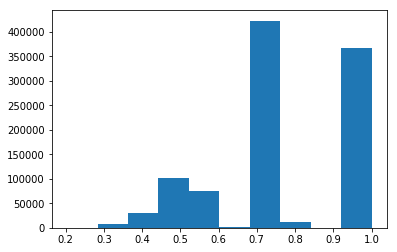

In [855]:
plt.hist([x for clip in parent_similarity for x in clip if x > 0])
plt.show()

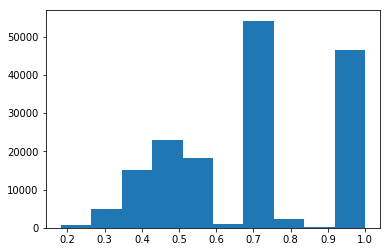

In [856]:
plt.hist([x for clip in secondary_similarity for x in clip if x > 0])
plt.show()

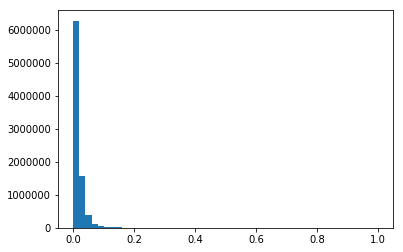

In [857]:
plt.hist([x for clip in caption_similarity for x in clip if x > 0], bins = 50)
plt.show()

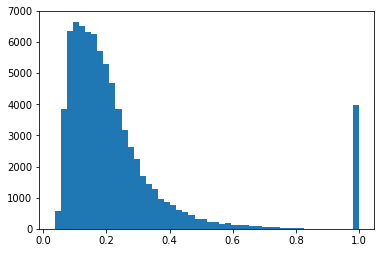

In [858]:
plt.hist([x for clip in title_similarity for x in clip if x > 0], bins = 50)
plt.show()

# IX. Analyzing number of connections in similarity matrices

## <font color = 'red'> As demonstrated below, there are not many clips that are 'isolated' with no similarities for each of the metrics we've chosen. Therefore we can feel comfortable proceeding.</color>

### Parent Categories -- 1,834 clips with no similarities to other clips

In [859]:
## Left column is number of nonzero similarities
## Right column is count of clips with this many nonzero similarities

pd.DataFrame(pd.DataFrame(parent_similarity).astype(bool).sum(axis=0).value_counts(), columns = ['count']).reset_index().sort_values('index')

,index,count
0,0,1834
39,15,3
17,34,16
36,43,4
13,44,27
26,51,8
20,59,11
104,65,1
11,73,42
76,86,1


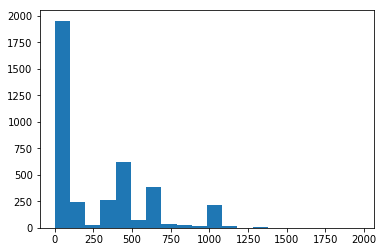

In [860]:
plt.hist(parent_similarity.astype(bool).sum(axis=0), bins = 20)
plt.show()

### Secondary Categories -- 2,712 clips with no similarities to other clips

In [861]:
## Left column is number of nonzero similarities
## Right column is count of clips with this many nonzero similarities

pd.DataFrame(pd.DataFrame(secondary_similarity).astype(bool).sum(axis=0).value_counts(), columns = ['count']).reset_index().sort_values('index')

,index,count
0,0,2710
101,1,2
28,2,8
57,3,4
48,4,4
45,5,5
82,6,2
30,7,8
23,9,10
26,10,9


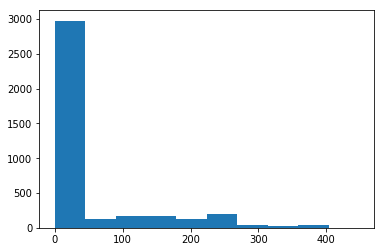

In [862]:
plt.hist(secondary_similarity.astype(bool).sum(axis=0))
plt.show()

### Captions -- 118 clips with no similarities to other clips

In [863]:
## Left column is number of nonzero similarities
## Right column is count of clips with this many nonzero similarities

pd.DataFrame(pd.DataFrame(caption_similarity).astype(bool).sum(axis=0).value_counts(), columns = ['count']).reset_index().sort_values('index')

,index,count
0,0,106
1,1,12
7,2,7
1480,3,1
1300,4,1
479,5,2
1482,7,1
1298,8,1
1484,9,1
478,12,2


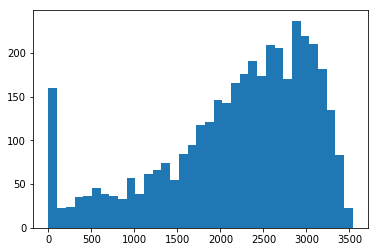

In [864]:
plt.hist(caption_similarity.astype(bool).sum(axis=0), bins = 35)
plt.show()

### Titles -- 765 clips with no similarities to other clips

In [865]:
## Left column is number of nonzero similarities
## Right column is count of clips with this many nonzero similarities

pd.DataFrame(pd.DataFrame(title_similarity).astype(bool).sum(axis=0).value_counts(), columns = ['count']).reset_index().sort_values('index')

,index,count
158,0,1
0,1,764
1,2,313
2,3,208
3,4,149
4,5,133
5,6,123
8,7,81
6,8,89
9,9,78


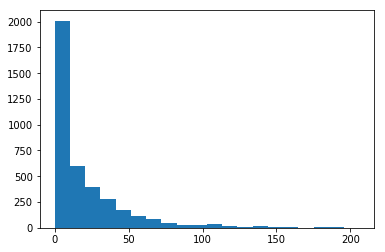

In [866]:
plt.hist(title_similarity.astype(bool).sum(axis=0), bins = 20)
plt.show()

# X. Function to find similar clips

### Converting similarity matrices to dataframes

In [867]:
parent_similarity = pd.DataFrame(parent_similarity, index = clip.clip_id, columns = clip.clip_id)
secondary_similarity = pd.DataFrame(secondary_similarity, index = clip.clip_id, columns = clip.clip_id)
caption_similarity = pd.DataFrame(caption_similarity, index = clip.clip_id, columns = clip.clip_id)
title_similarity = pd.DataFrame(title_similarity, index = clip.clip_id, columns = clip.clip_id)
period_similarity = pd.DataFrame(period_similarity, index = clip.clip_id, columns = clip.clip_id)

### Normalize and combine the similarities in helper function

In [868]:
## For each similarity matrix (categories, captions, titles)
## Given a clip_id input 'inp'
## Take list of similarity values to 'inp' and divide each by sum of similarity values (excluding self-similarity)
## This normalizes similarities -- accounts for different scale of similarity values across matrices AND
## Gives more weight to "rarer" connections

def normalize_combine_similarities(inp):
    
    cat1sim = caption_similarity.loc[inp].rename('sim_adj').reset_index()
    cat1sim = cat1sim[cat1sim.clip_id != inp]
    cat1sim['sim_adj'] = cat1sim['sim_adj'] / cat1sim['sim_adj'].sum()
    
    cat2sim = caption_similarity.loc[inp].rename('sim_adj').reset_index()
    cat2sim = cat2sim[cat2sim.clip_id != inp]
    cat2sim['sim_adj'] = cat2sim['sim_adj'] / cat2sim['sim_adj'].sum()
    
    capsim = caption_similarity.loc[inp].rename('sim_adj').reset_index()
    capsim = capsim[capsim.clip_id != inp]
    capsim['sim_adj'] = capsim['sim_adj'] / capsim['sim_adj'].sum()
    
    titlsim = caption_similarity.loc[inp].rename('sim_adj').reset_index()
    titlsim = titlsim[titlsim.clip_id != inp]
    titlsim['sim_adj'] = titlsim['sim_adj'] / titlsim['sim_adj'].sum()
    
    indices = clip.clip_id[clip.clip_id != inp]
    return pd.DataFrame(cat1sim['sim_adj'] + cat2sim['sim_adj'] + capsim['sim_adj'] + titlsim['sim_adj']).set_index(indices).reset_index()

### Function to output similar clips

In [869]:
def similar_clips(inp):
    
    output = []
    
    similarities = normalize_combine_similarities(inp)
    
    ## Number of clips with nonzero similarities
    num_sim_clips = similarities.astype(bool).sim_adj.sum()
    
    if num_sim_clips >= 10:
        
        output = list(similarities.sort_values('sim_adj', ascending = False)[:10].clip_id)
    
    else:
        
        output = list(similarities.sort_values('sim_adj', ascending = False)[:num_sim_clips].clip_id)
        for x in range(10 - num_sim_clips):
            output.append(list(title_similarity.loc[inp].sort_values(ascending=False)[1:(11 - num_sim_clips)].index))
            
    return output

# XI. Demonstrating Output

### Testing function for various clip_id's

In [870]:
import pprint

clip_id_list = [14434107, 249393804, 71964690, 78106175, 228236677, 11374425, 93951774, 35616659, 112360862, 116368488]

output_dict = {}
for x in clip_id_list:
    output_dict[x] = similar_clips(x)
    
pp = pprint.PrettyPrinter(indent = 2)
pp.pprint(output_dict)

{ 11374425: [ 62386108,
              4189528,
              3116167,
              5170940,
              65205680,
              32851562,
              5313987,
              126822765,
              4103767,
              56775813],
  14434107: [ 7243598,
              129033960,
              47584510,
              22669883,
              6876109,
              98330466,
              16487049,
              169539501,
              150834335,
              8167489],
  35616659: [ 6209117,
              164562375,
              137158633,
              13494671,
              46175751,
              10715005,
              105078498,
              40408860,
              114033533,
              4464887],
  71964690: [ 38205958,
              81815874,
              26125187,
              87672635,
              9940327,
              198143287,
              80890954,
              181118448,
              14450507,
              101340130],
  78106175: [ 38356,
              3